In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

import tensorflow as tf
from keras.models import Sequential, Model, save_model, load_model
from keras.applications import vgg16
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical, plot_model, set_random_seed

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
set_random_seed(42)

## 데이터 불러오기, 전처리, 스케일링

In [3]:
df=pd.read_excel('default of credit card clients.xls', index_col=0, header=1)
x=df.iloc[:, :-1]
y=df.iloc[:, -1]
x

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100


In [4]:
x.shape, y.shape

((30000, 23), (30000,))

In [5]:
scaler = StandardScaler()
x_scaled=scaler.fit_transform(x)

---
## PCA

In [6]:
pca = PCA()
pca.fit(x_scaled)

PCA()

In [7]:
# 주성분 행렬
pca.singular_values_

array([443.04929774, 350.6420357 , 215.70539822, 210.16175361,
       175.37713289, 169.45792011, 165.00799458, 163.18238146,
       161.67090383, 153.25759279, 148.26882983, 143.12454352,
       130.87573497, 125.42606134, 110.04188243,  88.29841154,
        86.45145711,  75.23782289,  62.87756995,  45.87669015,
        34.97910792,  27.54735755,  26.39274393])

In [8]:
# 주성분에 투영 후 분산 비율 정도 설명
pca.explained_variance_ratio_

array([0.28448215, 0.17818817, 0.06743307, 0.06401154, 0.04457556,
       0.04161737, 0.03946035, 0.03859201, 0.03788041, 0.03404042,
       0.03186036, 0.02968788, 0.02482385, 0.02279956, 0.01754959,
       0.01129943, 0.01083167, 0.00820396, 0.00572984, 0.00305025,
       0.00177324, 0.00109979, 0.00100953])

### **주성분 갯수 지정**
---  
- 방법 1) pca.explained_variance_ratio_의 누적값에서 원하는 분포정도 지정해서 PC 갯수 계산
- 방법 2) n_components = 0.0 ~ 1.0 : 주성분 투영된 데이터 분포 정도 지정하면 PC 갯수 자동 계산

In [9]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
# 누적값이 0.95가 필요한 경우
d = np.argmax(cumsum >=0.95) + 1
print((f'주성분 갯수(차원) : {d}'))

주성분 갯수(차원) : 15


In [10]:
# 지정된 PC 갯수로 주성분 데이터 압축/융합
pca2=PCA(n_components=d)
x_pca2=pca2.fit_transform(x_scaled)

In [11]:
# PCA한 후 x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(x_pca2, y, stratify=y, random_state=42, test_size=0.2)

# x_train, x_val, y_train, y_val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.2)

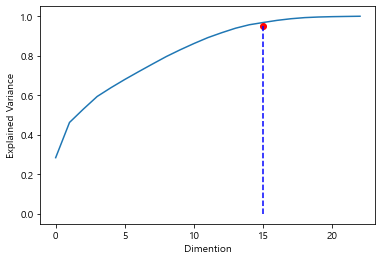

In [12]:
# 주성분과 데이터 투영 분산 정도 시각화
plt.plot(cumsum)
plt.plot(d, 0.95, 'ro')
plt.plot([15, 15], [0, 0.95], 'b--')
plt.xlabel("Dimention")
plt.ylabel("Explained Variance")
plt.show()

---
## 모델 구성

In [38]:
model=Sequential()

In [39]:
model.add(Dense(256, activation='relu', input_shape=(15,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               4096      
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 45,313
Trainable params: 45,313
Non-trai

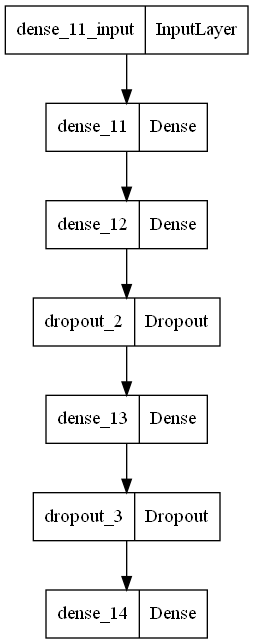

In [41]:
plot_model(model)

---
## 모델 생성

In [42]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [43]:
x_pca2.shape, y.shape

((30000, 15), (30000,))

## 모델 학습

In [44]:
EarlyStop = EarlyStopping(patience=10) # 몇 번동안 변화가 없으면 멈춤
# callbacks=[EarlyStop] # model.fit(callbacks=[EarlyStop] 리스트로 담기)

In [45]:
result = model.fit(x_train, y_train, batch_size=64,
                  epochs=100, validation_data=(x_val, y_val), callbacks=[EarlyStop])

Epoch 1/100
300/300 [==============================] - 1s 3ms/step - loss: 0.4765 - accuracy: 0.8053 - val_loss: 0.4538 - val_accuracy: 0.8123
Epoch 2/100
300/300 [==============================] - 1s 2ms/step - loss: 0.4464 - accuracy: 0.8180 - val_loss: 0.4508 - val_accuracy: 0.8144
Epoch 3/100
300/300 [==============================] - 1s 2ms/step - loss: 0.4409 - accuracy: 0.8184 - val_loss: 0.4442 - val_accuracy: 0.8135
Epoch 4/100
300/300 [==============================] - 1s 2ms/step - loss: 0.4364 - accuracy: 0.8192 - val_loss: 0.4459 - val_accuracy: 0.8115
Epoch 5/100
300/300 [==============================] - 1s 2ms/step - loss: 0.4331 - accuracy: 0.8206 - val_loss: 0.4469 - val_accuracy: 0.8125
Epoch 6/100
300/300 [==============================] - 1s 2ms/step - loss: 0.4324 - accuracy: 0.8191 - val_loss: 0.4449 - val_accuracy: 0.8144
Epoch 7/100
300/300 [==============================] - 1s 3ms/step - loss: 0.4307 - accuracy: 0.8205 - val_loss: 0.4436 - val_accuracy: 0.8125

In [46]:
model.evaluate(x_train, y_train)

600/600 [==============================] - 1s 1ms/step - loss: 0.3942 - accuracy: 0.8327


[0.3942181169986725, 0.8326562643051147]

In [47]:
model.evaluate(x_test, y_test)

188/188 [==============================] - 0s 1ms/step - loss: 0.4432 - accuracy: 0.8145


[0.443185955286026, 0.8144999742507935]

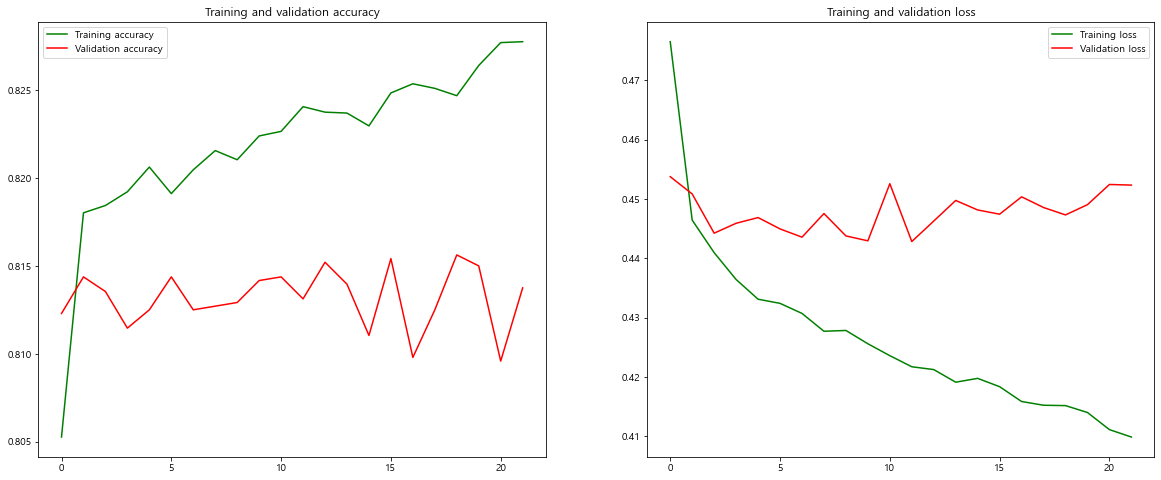

In [48]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(20, 8))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend(fontsize=10)
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(result)